# !!!!!!NOTE!!!!!
### we are going to use VXT now (Achtibat et al. 2024). See docs:
 https://github.com/rachtibat/LRP-eXplains-Transformers
 https://lxt.readthedocs.io/en/latest/quickstart.html

### rather than Chefer et al. 2021: https://arxiv.org/abs/2012.09838


#### next steps
- download open_clip and adjust it to take X input channels. 

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import Dataset, DataLoader

import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import copy
import os

from einops import rearrange
from einops.layers.torch import Rearrange

import Simple_ViT.simple_vit as svit
import Simple_ViT.simple_vit_lrp as svitl

import importlib
# When you need to reload the module after an update
importlib.reload(svitl)

import getpass
myname = getpass.getuser()

import pandas as pd
import lxt.functional as lf


## Dask

In [2]:
doDask = False
if doDask:
    print('...setting up dask client...')
    if 'client' in locals():
        client.shutdown()
        print('...shutdown client...')
    else:
        print('client does not exist yet')

    # ### ++++++ dask NCAR client: 
    from distributed import Client
    from dask_jobqueue import PBSCluster
    project_num = 'P03010039' #'P03010039' #what project key do you have? 
    
    cluster = PBSCluster(account=project_num,
                         walltime='12:00:00',
                         cores=1,
                         memory='40GB',
                         shared_temp_directory='/glade/derecho/scratch/kjmayer/tmp',
                         queue='casper')
    cluster.scale(jobs=40)
    client = Client(cluster)
    print(client) 

## GPU Handling

In [3]:
print(torch.cuda.is_available())

True


In [4]:
def set_gpu(gpu_id):
    os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
    os.environ["CUDA_VISIBLE_DEVICES"] = str(gpu_id)
    
gpu_id=0

if gpu_id >= 0:
    device = "cuda"
    set_gpu(gpu_id)
    print('device available :', torch.cuda.is_available())
    print('device count: ', torch.cuda.device_count())
    print('current device: ',torch.cuda.current_device())
    print('device name: ',torch.cuda.get_device_name())
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
else:
    device = torch.device('cpu')

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

print('using device: ', device)

device available : True
device count:  1
current device:  0
device name:  NVIDIA A100-SXM4-80GB
NVIDIA A100-SXM4-80GB
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB
using device:  cuda


## Load the Data

In [6]:
myname = 'kjmayer'
dirout = f'/glade/derecho/scratch/{myname}/TOMSensoDS/'
# Check if the directory exists
if not os.path.exists(dirout):
    # Create the directory
    os.makedirs(dirout)
    print(f"Directory {dirout} created.")
else:
    print(f"Directory {dirout} already exists.")

DSmean_sst_anom = xr.open_dataset(os.path.join(dirout, 'SST_CESM2_PI_Chunked.nc'))
print('...done loading SST...')

DSmean_trefht_anom_roll = xr.open_dataset(os.path.join(dirout, 'TREFHT_CESM2_PI_Chunked.nc'))
print('...done loading TREFHT...')
# /glade/derecho/scratch/negins/SST_CESM2_PI_chunked.nc

DSmean_sst_anom['time'] = DSmean_trefht_anom_roll['time']

Directory /glade/derecho/scratch/kjmayer/TOMSensoDS/ already exists.
...done loading SST...
...done loading TREFHT...


In [7]:
# chunk_sizes = {'SST': {'time': 64, 'lat': 192, 'lon': 288},'TREHT':{'time': 64, 'lat': 42, 'lon': 41}}
# DSmean_sst_anom.SST.chunk(chunk_sizes['SST'])
# DSmean_trefht_anom_roll.TREHT.chunk(chunk_sizes['TREHT'])

# DSmean_sst_anom.to_netcdf(dirout+"SST_CESM2_PI_Chunked.nc", 
#                           encoding={'SST': {'chunksizes': [chunk_sizes['SST']['time'],
#                                                            chunk_sizes['SST']['lat'],
#                                                            chunk_sizes['SST']['lon']]}})

# DSmean_trefht_anom_roll.to_netcdf(dirout+"TREFHT_CESM2_PI_Chunked.nc", 
#                                   encoding={'TREHT': {'chunksizes': [chunk_sizes['TREHT']['time'],
#                                                                    chunk_sizes['TREHT']['lat'],
#                                                                    chunk_sizes['TREHT']['lon']]}})

In [8]:
if doDask: 
    DSmean_sst_anom = DSmean_sst_anom.chunk({'time':5})
    DSmean_trefht_anom_roll = DSmean_trefht_anom_roll.chunk({'time':5})
    DSmean_sst_anom = DSmean_sst_anom.chunk({'time':5})

DSmean_sst_anom.SST

<xarray.DataArray 'SST' (time: 182501, lat: 192, lon: 288)>
[10091575296 values with dtype=float32]
Coordinates:
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * time     (time) datetime64[ns] 1700-01-01 1700-01-02 ... 2200-01-01

## Let's Lag this Bad Baby

In [9]:
%%time
print('here we go')
lead_time = 30
DSmean_sst_anom_lag = DSmean_sst_anom.isel(time=slice(0,-lead_time))
DSmean_trefht_anom_roll_lag = DSmean_trefht_anom_roll.isel(time=slice(lead_time,len(DSmean_trefht_anom_roll['time'])))

##################################################
##### 1700 - 2000
##################################################

date_range = pd.date_range(start='1700-01-01', end='2000-01-01')
# Filter out February 29th
filtered_date_range = date_range[~((date_range.month == 2) & (date_range.day == 29))]\
# Display the filtered date range
end_date_300 = len(filtered_date_range)

print('...gather training...')
y_train = DSmean_trefht_anom_roll_lag.isel(time=slice(0,end_date_300-1))
y_train_anom = y_train.groupby('time.dayofyear') - y_train.groupby('time.dayofyear').mean()
x_train = DSmean_sst_anom_lag.isel(time=slice(0,end_date_300-1))
x_train_anom = x_train.groupby('time.dayofyear') - x_train.groupby('time.dayofyear').mean()

##################################################
##### 2000 - 2100
##################################################
date_range = pd.date_range(start='1700-01-01', end='2101-01-01')
# Filter out February 29th
filtered_date_range = date_range[~((date_range.month == 2) & (date_range.day == 29))]\
# Display the filtered date range
indy_val_s = int(np.where(filtered_date_range == '2000-01-01')[0])
indy_val_e = int(np.where(filtered_date_range == '2100-01-01')[0])

print('...gather validation...')
y_val = DSmean_trefht_anom_roll_lag.isel(time=slice(indy_val_s,indy_val_e))
y_val_anom = y_val.groupby('time.dayofyear') - y_val.groupby('time.dayofyear').mean()
x_val = DSmean_sst_anom_lag.isel(time=slice(indy_val_s,indy_val_e))
x_val_anom = x_val.groupby('time.dayofyear') - x_val.groupby('time.dayofyear').mean()

##################################################
##### 2000 - 2100
##################################################

date_range = pd.date_range(start='1700-01-01', end='2201-01-01')
# Filter out February 29th
filtered_date_range = date_range[~((date_range.month == 2) & (date_range.day == 29))]\
# Display the filtered date range
indy_test_s = int(np.where(filtered_date_range == '2100-01-01')[0])
indy_test_e = int(np.where(filtered_date_range == '2200-01-01')[0])

print('...gather testing...')
y_test = DSmean_trefht_anom_roll_lag.isel(time=slice(indy_test_s,indy_test_e))
y_test_anom = y_test.groupby('time.dayofyear') - y_test.groupby('time.dayofyear').mean()
x_test = DSmean_sst_anom_lag.isel(time=slice(indy_test_s,indy_test_e))
x_test_anom = x_test.groupby('time.dayofyear') - x_test.groupby('time.dayofyear').mean()
print('done')

here we go
...gather training...
...gather validation...
...gather testing...
done
CPU times: user 3min 25s, sys: 3min 53s, total: 7min 19s
Wall time: 12min 15s


In [10]:
%%time
## WHY IS THERE AN IF ELSE STATMENT HERE??
if doDask:
    np_arr_x_train_anom = np.array(x_train_anom['SST'])
    np_arr_x_val_anom = np.array(x_val_anom['SST']) 
    np_arr_y_train_anom = np.array(y_train_anom['TREHT'])
    np_arr_y_val_anom = np.array(y_val_anom['TREHT'])
else:
    np_arr_x_train_anom = np.array(x_train_anom['SST'])
    np_arr_x_val_anom = np.array(x_val_anom['SST']) 
    np_arr_y_train_anom = np.array(y_train_anom['TREHT'])
    np_arr_y_val_anom = np.array(y_val_anom['TREHT'])

CPU times: user 1.46 s, sys: 2.42 s, total: 3.89 s
Wall time: 3.88 s


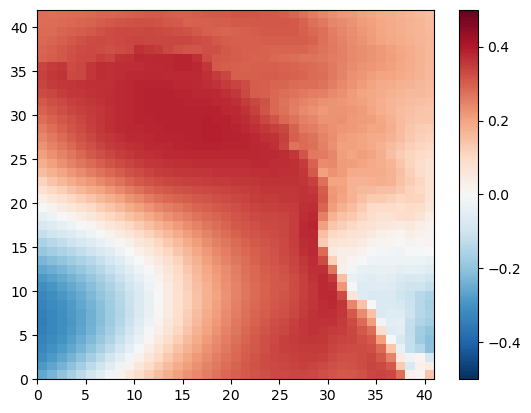

CPU times: user 2.01 s, sys: 34.9 ms, total: 2.04 s
Wall time: 2.04 s


In [13]:
%%time
# Find a good location to predict
enso = x_train_anom['SST'].sel(lat=slice(-5,5),lon=slice(190,240)).mean(('lat','lon'))
nino = enso.where(enso >= 2, drop=True).load()
nina = enso.where(enso <= -2, drop=True).load()
notenso = enso.where((enso > -2) & (enso < 2), drop=True).load()
notnino = enso.where(enso < 2, drop=True).load()

corrs = np.zeros(shape=(42,41))
for ilat in np.arange(0,len(y_train_anom['TREHT'].lat)):
    for ilon in np.arange(0,len(y_train_anom['TREHT'].lon)):
        corrs[ilat,ilon] = np.corrcoef(enso,y_train_anom['TREHT'][:, ilat, ilon])[0,1]

plt.pcolormesh(corrs,cmap='RdBu_r',vmin=-.5,vmax=.5)
plt.colorbar()
plt.show()

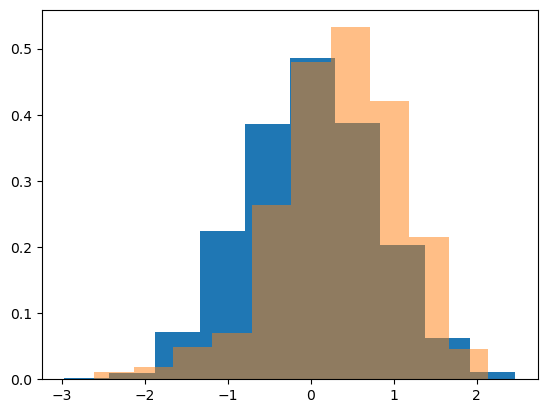

In [70]:
# Define & Check Predictand Point (do not delete this bad boy; vital for exsistence)
yenso = x_train_anom['SST'][lead_time:].sel(lat=slice(-5,5),lon=slice(190,240)).mean(('lat','lon'))
ynino = yenso.where(yenso >= 2, drop=True).load()
ynina = yenso.where(yenso <= -2, drop=True).load()
ynotenso = yenso.where((yenso > -2) & (yenso < 2), drop=True).load()

ilat = 25
flat = 35
ilon = 10
flon = 20

yall = y_train_anom['TREHT'][:, ilat:flat, ilon:flon].mean(('lat','lon')).sel(time=ynotenso.time)
ynino = y_train_anom['TREHT'][:, ilat:flat, ilon:flon].mean(('lat','lon')).sel(time=ynino.time)

plt.hist(yall,density=True)
plt.hist(ynino,density=True,alpha=0.5)
plt.show()

## Data Loader

In [5]:
class SpatialDataset(Dataset):
    def __init__(self, X, y):
        randi = np.random.choice(range(np.shape(X)[0]),size=np.shape(X)[0])
        self.X = torch.nan_to_num(torch.tensor(X[randi], dtype=torch.float32))
        self.y = torch.tensor(np.mean(y[randi,ilat:flat,ilon:flon],axis=(1,2)), dtype=torch.float32) #of the coast NW NA
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx].unsqueeze(0), self.y[idx].unsqueeze(0)

## Model

In [7]:
import operator
import itertools
import torch
import torch.nn as nn
import torch.nn.functional as F
from lxt.core import Composite
import lxt.functional as lf
import lxt.modules as lm
import lxt.rules as rules

import open_clip
import open_clip.transformer
from zennit.composites import LayerMapComposite

In [8]:
import open_clip
from PIL import Image
from zennit.composites import LayerMapComposite
import zennit.rules as z_rules
from zennit.image import imgify

In [9]:
modelvv = open_clip.transformer.VisionTransformer(image_size=(192,288),
                                                  patch_size=16, 
                                                  width=32,layers=4,
                                                  heads=2,
                                                  mlp_ratio=2,
                                                  output_dim=1)

In [10]:
x = torch.randn(1, 3, 192, 288, device=device)
XXX = modelvv.to(device)(x)

In [11]:
attnlrp = Composite({
        nn.MultiheadAttention: lm.MultiheadAttention_CP,
        # order matters! lm.LinearInProjection is inside lm.MultiheadAttention_CP
        lm.LinearInProjection: rules.EpsilonRule,
        lm.LinearOutProjection: rules.EpsilonRule,
        open_clip.transformer.LayerNorm: lm.LayerNormEpsilon,
        nn.GELU: rules.IdentityRule,
        operator.add: lf.add2,
        operator.matmul: lf.matmul,
        F.normalize: lf.normalize,
    })

In [12]:
heatmaps=[]
device='cuda'
x = torch.randn(1, 3, 192, 288, device=device, requires_grad=True)
modelvv.eval()
modelvv = modelvv.to(device)
traced = attnlrp.register(modelvv, dummy_inputs={'x': x}, verbose=True)
traced
conv_gamma = 0.5
lin_gamma = 0.05
zennit_comp = LayerMapComposite([
            (torch.nn.Conv2d, z_rules.Gamma(conv_gamma)),
            (torch.nn.Linear, z_rules.Gamma(lin_gamma)),
        ])
        # register composite
zennit_comp.register(traced)
# forward & backward pass
y = traced(x.requires_grad_(True))
y = lf.mean(y,dim=0,keep_dim=True)
# y.backward()
# normalize the heatmap
x.grad = None
y.backward()
heatmap = x.grad[0].sum(0)
heatmap = heatmap / abs(heatmap).max()
heatmaps.append(heatmap.cpu().numpy())

# zennit composites can be removed so that we can register a new one!
zennit_comp.remove()

/glade/work/wchapman/miniconda3.1/envs/MLWPS/lib/python3.11/site-packages/torch/overrides.py:110: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  torch.has_cuda,
/glade/work/wchapman/miniconda3.1/envs/MLWPS/lib/python3.11/site-packages/torch/overrides.py:111: UserWarning: 'has_cudnn' is deprecated, please use 'torch.backends.cudnn.is_available()'
  torch.has_cudnn,
/glade/work/wchapman/miniconda3.1/envs/MLWPS/lib/python3.11/site-packages/torch/overrides.py:117: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  torch.has_mps,
/glade/work/wchapman/miniconda3.1/envs/MLWPS/lib/python3.11/site-packages/torch/overrides.py:118: UserWarning: 'has_mkldnn' is deprecated, please use 'torch.backends.mkldnn.is_available()'
  torch.has_mkldnn,


+--------------------------------------------------------+--------------------------------------------------------+------------+------------------+
| Parent Module                                          | Function                                               | Replaced   | LRP compatible   |
+========================================================+========================================================+============+==================+
| <class 'torch.nn.modules.conv.Conv2d'>                 | -                                                      | -          |  ⁇               |
+--------------------------------------------------------+--------------------------------------------------------+------------+------------------+
| <class 'torch.nn.modules.linear.Identity'>             | -                                                      | -          |  ⁇               |
+--------------------------------------------------------+------------------------------------------------------

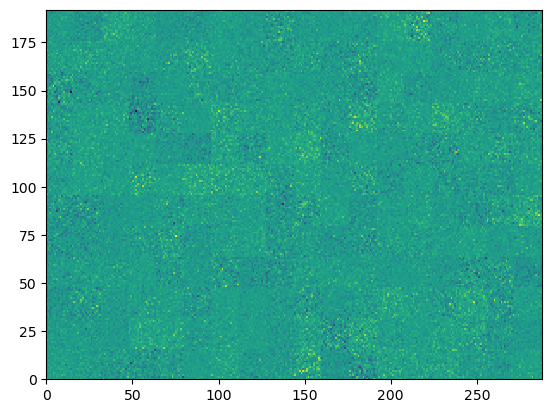

In [14]:
plt.pcolor(heatmaps[0])
plt.show()

## Train with old model

In [72]:
batch_size = 64
input_shape = (1, 1, 192, 288) # Example input shape (C, H, W)


#(self, img_size=224, patch_size=16, in_chans=3, num_classes=1000, embed_dim=768, depth=12,num_heads=12, mlp_ratio=4., qkv_bias=False, mlp_head=False, drop_rate=0., attn_drop_rate=0.):

model = svitl.VisionTransformer(
        image_lr = 192,
        image_ud = 288,
        patch_size = 16,
        num_classes = 1,
        in_chans = 1,
        embed_dim = 3,
        depth = 2,
        num_heads = 3,
        mlp_ratio = 2.,
    ).to(device)



criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

train_dataset = SpatialDataset(np_arr_x_train_anom, np_arr_y_train_anom )
val_dataset = SpatialDataset(np_arr_x_val_anom, np_arr_y_val_anom)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

## Train

In [ ]:
num_epochs = 1000
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    print(f"Starting Epoch {epoch}")
    nsampsseen = 0
    running_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        nsampsseen += inputs.shape[0]
        if nsampsseen > 30000:
            break
    epoch_loss = running_loss / nsampsseen
    print(f"Epoch {epoch}, Loss: {epoch_loss:.4f}")

    # Validation loop
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    mse_val_batch=[]
    labels_full = []
    outputs_full = []
    with torch.no_grad():  # In validation phase, we don't need to compute gradients
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs.to(device))
            mse_val_batch.append((torch.mean((outputs-labels)**2)))
            labels_full.append(labels)
            outputs_full.append(outputs)
    # Calculate and print validation accuracy
    mse_tot=torch.mean(torch.tensor(mse_val_batch))
    
    print(f"MSE: {mse_tot:.5f}")
    print( f"r2: {1-(mse_tot/np.var(np_arr_y_val_anom[:, ilat, ilon]))}")
    
    if epoch == 0:
        print('...saved first epoch...')
        best_mod = copy.deepcopy(model)
        best_acc = copy.deepcopy(mse_tot)
    elif mse_tot<best_acc:
        print('...saving!...')
        best_mod = copy.deepcopy(model)
        best_acc = copy.deepcopy(mse_tot)
    else:
        print('No improvement in validation accuracy.')
    # Step the scheduler on each epoch
    scheduler.step(mse_tot)

Starting Epoch 0
Epoch 0, Loss: 0.5255
MSE: 0.53760
r2: -0.08711743354797363
...saved first epoch...
Starting Epoch 1
Epoch 1, Loss: 0.4542
MSE: 0.50767
r2: -0.026589155197143555
...saving!...
Starting Epoch 2
Epoch 2, Loss: 0.4181
MSE: 0.49536
r2: -0.0016968250274658203
...saving!...
Starting Epoch 3
Epoch 3, Loss: 0.3966
MSE: 0.47612
r2: 0.037208497524261475
...saving!...
Starting Epoch 4
Epoch 4, Loss: 0.3767
MSE: 0.46715
r2: 0.05533987283706665
...saving!...
Starting Epoch 5
Epoch 5, Loss: 0.3621
MSE: 0.45665
r2: 0.07657957077026367
...saving!...
Starting Epoch 6
Epoch 6, Loss: 0.3528
MSE: 0.45493
r2: 0.08004790544509888
...saving!...
Starting Epoch 7
Epoch 7, Loss: 0.3420
MSE: 0.46729
r2: 0.05506628751754761
No improvement in validation accuracy.
Starting Epoch 8
Epoch 8, Loss: 0.3367
MSE: 0.46446
r2: 0.06079202890396118
No improvement in validation accuracy.
Starting Epoch 9
Epoch 9, Loss: 0.3299
MSE: 0.45482
r2: 0.08028846979141235
...saving!...
Starting Epoch 10
Epoch 10, Loss:

In [43]:
labels_list = torch.cat(labels_full).cpu()
outputs_list = torch.cat(outputs_full).cpu()

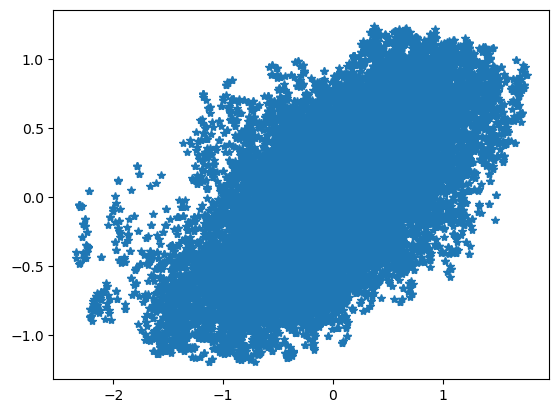

array([[1.        , 0.64742232],
       [0.64742232, 1.        ]])

In [59]:
plt.plot(np.array(labels_list),np.array(outputs_list),'*')
plt.show()
np.corrcoef(np.array(labels_list).squeeze(),np.array(outputs_list).squeeze())

In [ ]:
labels = labels.to(device)
outputs = model(inputs.to(device))

In [28]:
outputs.shape

torch.Size([20, 1])

In [85]:
Xval_check = torch.nan_to_num(torch.tensor(np_arr_x_val_anom, dtype=torch.float32)).unsqueeze(0)
Xval_check_flipped = Xval_check.transpose(0,1)
print('...predicting...')
with torch.no_grad():
    pred = model(Xval_check_flipped[-7000:].to(device))
    true = torch.tensor(np_arr_y_val_anom[-7000:, ilat, ilon], dtype=torch.float32)
    pred = pred.squeeze()
    true = true.squeeze()

mse = np.mean((pred.cpu().detach().numpy() - true.cpu().detach().numpy())**2)
print(mse) # this looks reasonable...
r2 = 1 - (mse/np.var(true.cpu().detach().numpy()))
print(r2) # WHY IS THIS NEGATIVE?? Should be close to 0.36

corr = np.corrcoef(pred.cpu().detach().numpy(),true.cpu().detach().numpy())
print(corr)

...predicting...
0.27825418
0.3047060966491699
[[1.         0.58094623]
 [0.58094623 1.        ]]


array([[1.        , 0.58094623],
       [0.58094623, 1.        ]])

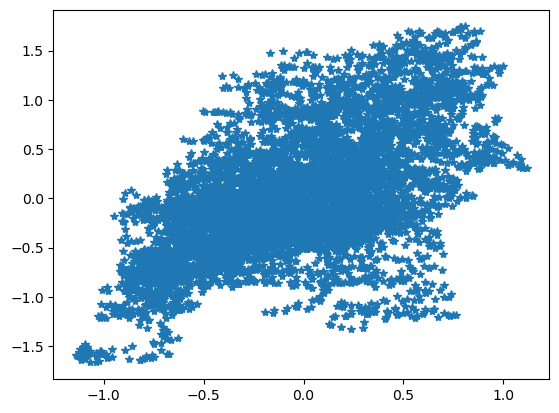

In [86]:
plt.plot(np.array(pred.cpu()),np.array(true.cpu()),'*')
np.corrcoef(np.array(pred.cpu()).squeeze(),np.array(true.cpu()).squeeze())

In [88]:
# trying Tony idea to fit a linear model
true_std = (true.cpu().detach().numpy() - np.mean(true.cpu().detach().numpy(),axis=0))/np.std(true.cpu().detach().numpy(),axis=0)
pred_std = (pred.cpu().detach().numpy() - np.mean(pred.cpu().detach().numpy(),axis=0))/np.std(pred.cpu().detach().numpy(),axis=0)

pred_linear = 0.58094623*pred_std*np.std(true.cpu().detach().numpy(),axis=0) + np.mean(true.cpu().detach().numpy(),axis=0)
1-(np.mean((pred_linear - true.cpu().detach().numpy())**2)/np.var(true.cpu().detach().numpy()))

0.33749860525131226

In [89]:
# plt.plot(Yval_check.cpu().detach().numpy())
# plt.plot(Xval_outputs.cpu().detach().numpy())
# plt.show()

# plt.plot(Xval_outputs.cpu().detach().numpy(),Yval_check.cpu().detach().numpy(),linewidth=0,marker='.')
# plt.xlim(-1.5,1.5)
# plt.ylim(-1.5,1.5)
# plt.show()

In [90]:
print('...setting up dask client...')
if 'client' in locals():
    client.shutdown()
    print('...shutdown client...')
else:
    print('client does not exist yet')


...setting up dask client...
...shutdown client...


In [25]:
# import gc
# gc.collect()
# torch.cuda.empty_cache()